In [0]:
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse as sp
from tqdm import tqdm_notebook as tqdm
import torch
from IPython.display import HTML

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
# path = '/content/drive/My\ Drive/Colab\ Notebooks/CBIR/corel1.zip'

In [0]:
# !unzip -qq $path -d corel

In [8]:
# files = os.listdir('./corel/Corel100/')
# len(files)

10001

In [9]:
#  [i for i in files if i.split('.')[1]=='db']

['Thumbs.db']

In [0]:
# os.remove('./corel/Corel100/Thumbs.db')
# os.remove(os.path.join(ROOT, files[5809]))

In [0]:
ROOT = './corel/Corel100/'
n_dims = 25088

In [0]:
class CBIRDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images = os.listdir(root)
        self.transforms = transforms

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx]))
        img = self.transforms(img)
        return idx, img

    def __len__(self):
        return len(self.images)

In [0]:
transforms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dsetCBIR = CBIRDataset(ROOT, transforms)

In [0]:
dataloader = DataLoader(dsetCBIR, batch_size=64)

In [15]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [0]:
model.classifier = Identity()

In [18]:
preds = sp.lil_matrix((len(dsetCBIR), n_dims))
preds.shape

(10000, 25088)

In [19]:
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for i, img in tqdm(dataloader):
    pred = model(img.to(device))
    preds[i.min() : i.max() + 1, :] = pred.cpu().detach()

In [0]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [65]:
preds = preds.tocsr()
sim = cosine_similarity(preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def get_thumbnails(sim, idx, N=10):
    row = sim[idx, :]
    thumbs = []
    files = os.listdir(ROOT)

    for x in np.argsort(-row)[:N]:

        thumbs.append(files[x])
    
    return thumbs

In [0]:
def display_thumbs(thumbs, N=9):

    display(HTML('<font size=5>'+'Query Image'+'</font>'))

    fig, ax = plt.subplots(figsize=(3,3))
    ax.axis('off')
    ax.imshow(Image.open(os.path.join(ROOT, thumbs[0])))
    plt.show()

    display(HTML('<font size=5>'+'Retrieved Images'+'</font>'))


    fig = plt.figure(figsize=(10, 10))

    for i, img in enumerate(thumbs[1:N+1]):
        image = Image.open(os.path.join(ROOT, img))
        fig.add_subplot(3, 3, i+1)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

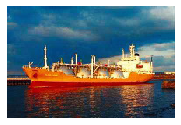

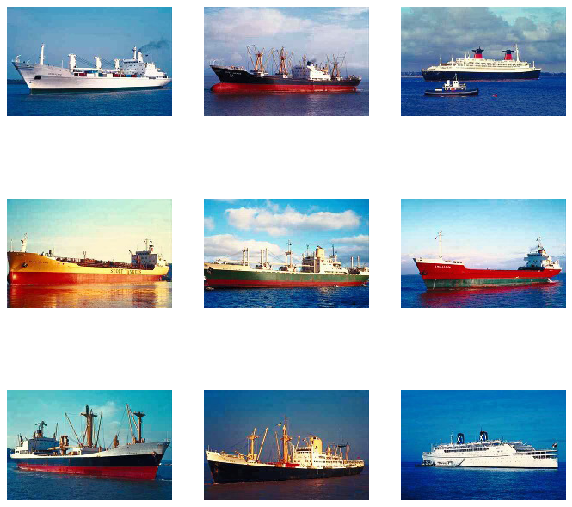

In [114]:
display_thumbs(get_thumbnails(sim, 999, N=10), N=9)